# EDSR

In [ ]:
## for colab, make sure it uses python 3.8
!sudo update-alternatives --config python3
!sudo apt install python3-pip

In [1]:
# !pip install tensorflow-gpu==2.3.1 tensorflow-addons==0.11.2 ## replace to !pip install tensorflow for CPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 23 kB/s 
     |████████████████████████████████| 1.1 MB 55.9 MB/s 
     |████████████████████████████████| 459 kB 62.0 MB/s 
     |████████████████████████████████| 2.9 MB 59.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      

In [2]:
# !git clone https://github.com/IritaSee/super-resolution-colab.git

Cloning into 'super-resolution'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 408 (delta 0), reused 2 (delta 0), pack-reused 405
Receiving objects: 100% (408/408), 48.16 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (214/214), done.


In [3]:
# %cd super-resolution

/content/super-resolution


In [1]:
!ls

article.ipynb		docs		     example_wdsr.ipynb  README.md
data_engineering.ipynb	environment.yml      LICENSE		 train.py
data.py			example_edsr.ipynb   model		 utils.py
demo			example_srgan.ipynb  __pycache__	 weights


In [2]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer

%matplotlib inline

2022-12-15 22:52:40.074560: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [30]:
# Number of residual blocks
# depth = 16
# depth = 8
depth = 32

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [36]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights_edsr_depth32.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets


In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [33]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-edsr-16-x4.tar.gz](https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/edsr-16-x4` directory containing the weights of the pre-trained model.

In [7]:
!wget https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz

--2022-12-15 22:53:11--  https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz
Resolving martin-krasser.de (martin-krasser.de)... 217.160.0.142, 2001:8d8:100f:f000::209
Connecting to martin-krasser.de (martin-krasser.de)|217.160.0.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5653330 (5,4M) [application/gzip]
Saving to: ‘weights-edsr-16-x4.tar.gz’

weights-edsr-16-x4. 100%[===================>]   5,39M   809KB/s    in 6,8s    

2022-12-15 22:53:20 (810 KB/s) - ‘weights-edsr-16-x4.tar.gz’ saved [5653330/5653330]



In [8]:
! tar -xf weights-edsr-16-x4.tar.gz

In [34]:
trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

In [35]:
# Train EDSR model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
# Uncomment codes below for training!
trainer.train(train_ds,
              valid_ds.take(10),
              steps=300000, 
              evaluate_every=1000, 
              save_best_only=True)

1000/300000: loss = 33.692, PSNR = 28.935810 (951.14s)
2000/300000: loss = 5.834, PSNR = 32.066566 (946.74s)
3000/300000: loss = 4.279, PSNR = 33.148006 (938.79s)
4000/300000: loss = 3.700, PSNR = 34.104988 (942.51s)
5000/300000: loss = 3.306, PSNR = 35.103264 (940.53s)
6000/300000: loss = 3.048, PSNR = 35.916183 (938.33s)
7000/300000: loss = 2.796, PSNR = 37.092220 (938.55s)
8000/300000: loss = 2.590, PSNR = 37.969746 (939.80s)
9000/300000: loss = 2.373, PSNR = 38.482918 (936.88s)
10000/300000: loss = 2.234, PSNR = 38.924423 (938.07s)
11000/300000: loss = 2.122, PSNR = 39.114853 (935.91s)
12000/300000: loss = 2.078, PSNR = 39.460304 (935.59s)
13000/300000: loss = 1.986, PSNR = 39.605736 (935.12s)
14000/300000: loss = 1.934, PSNR = 39.732845 (934.88s)
15000/300000: loss = 1.902, PSNR = 39.489807 (935.59s)
16000/300000: loss = 1.868, PSNR = 40.120659 (936.96s)
17000/300000: loss = 1.796, PSNR = 40.198952 (935.98s)
18000/300000: loss = 1.771, PSNR = 40.140625 (934.38s)
19000/300000: loss

In [12]:
# Restore from checkpoint with highest PSNR
trainer.restore()

In [37]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Validation (PSNR Score)

In [38]:
# Evaluate model on full validation set
psnrv = trainer.evaluate(valid_ds)
print(f'PSNR = {psnrv.numpy():3f}')

PSNR = 44.416874


## Demo

In [39]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [40]:
from model import resolve_single
from utils import load_image
from PIL import Image
import numpy as np

def convert_and_plot(lr_image_path):
    lr = np.array(Image.open(lr_image_path).convert('RGB'))
    
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

In [41]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

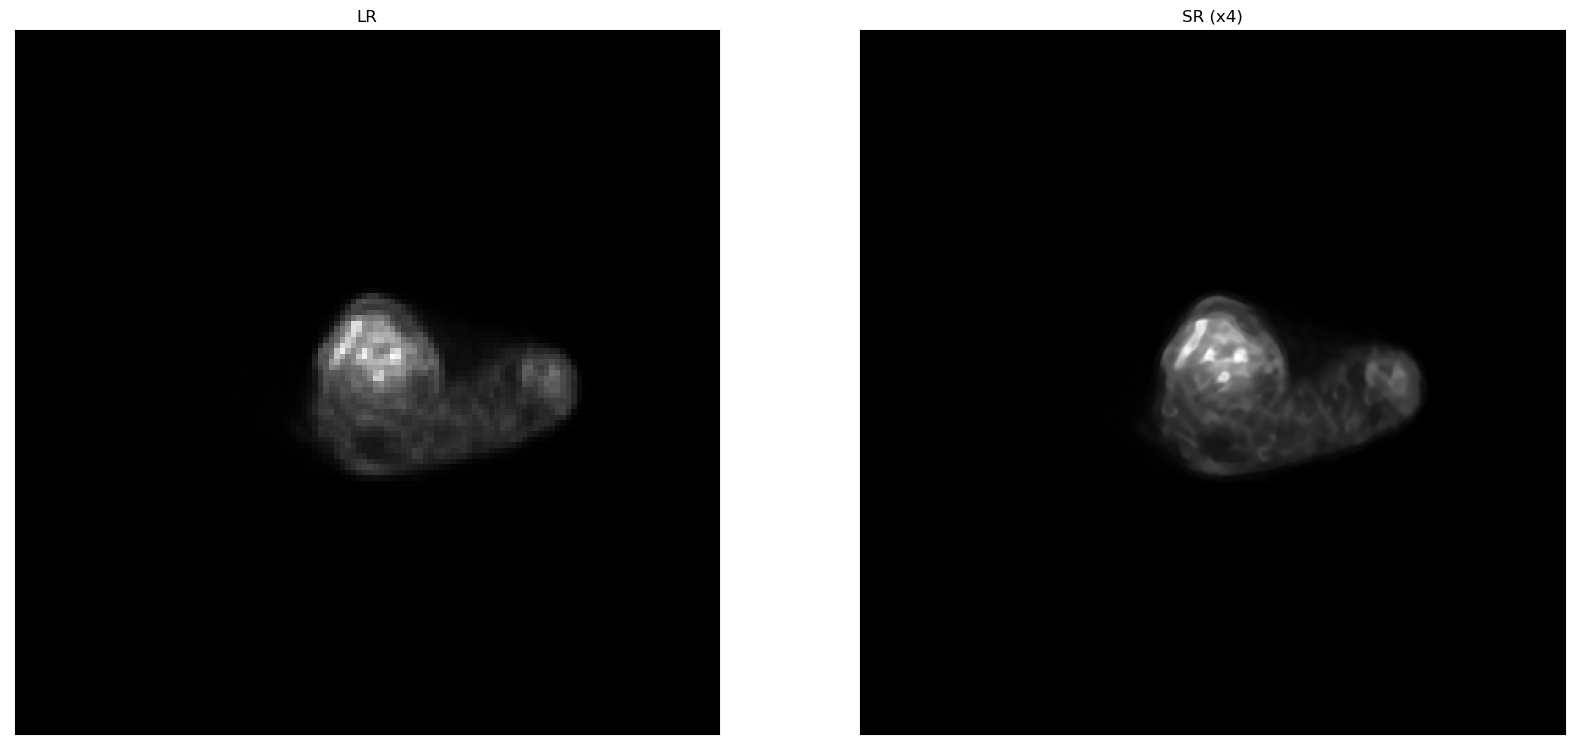

In [42]:
new_image = '/home/iga/super-resolution-master/new_dataset/PET-radiomics-challenges-kaggle/Training/1.3.6.1.4.1.14519.5.2.1.1707.8040.10059866353110167322451781.png'
convert_and_plot(new_image)

## SSIM : From Demo Image

In [43]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
new_image = '/home/iga/super-resolution-master/new_dataset/Y-90/downscaled/0150x4.png'

In [44]:
# load the two input images
lr = np.array(Image.open(new_image).convert('RGB'))
sr = resolve_single(model, lr)
imageA = cv2.imread('/home/iga/super-resolution-master/new_dataset/Y-90/normal/0150.png')
imageB = np.array(sr)
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)

In [45]:
# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.9764017264771029


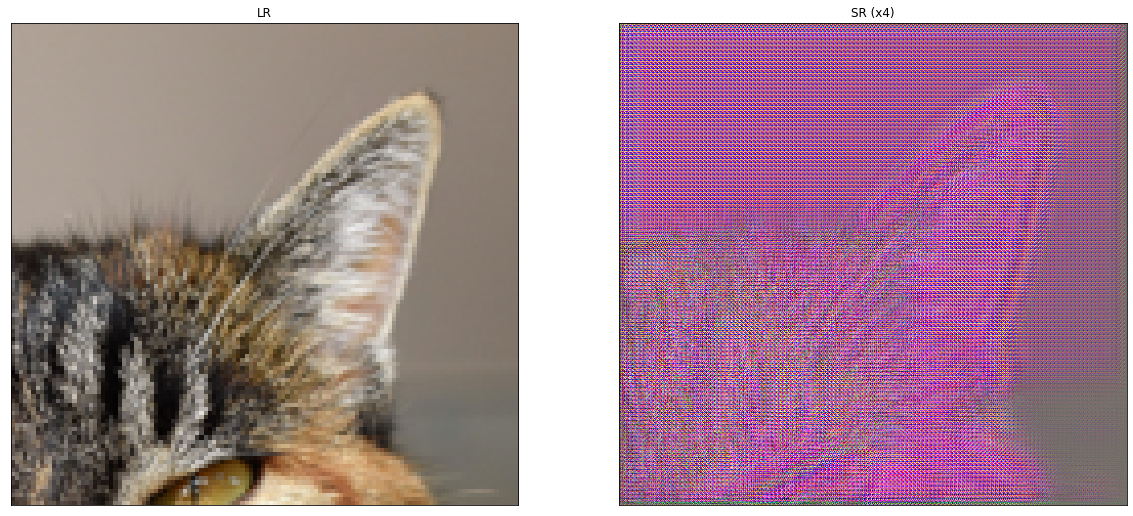

In [ ]:
resolve_and_plot('demo/0869x4-crop.png')

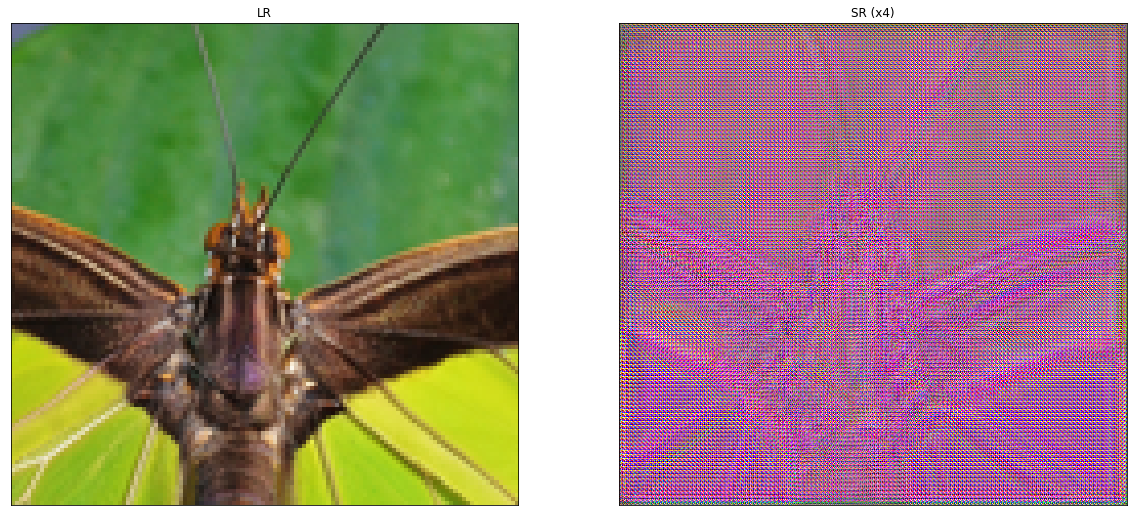

In [ ]:
resolve_and_plot('demo/0829x4-crop.png')

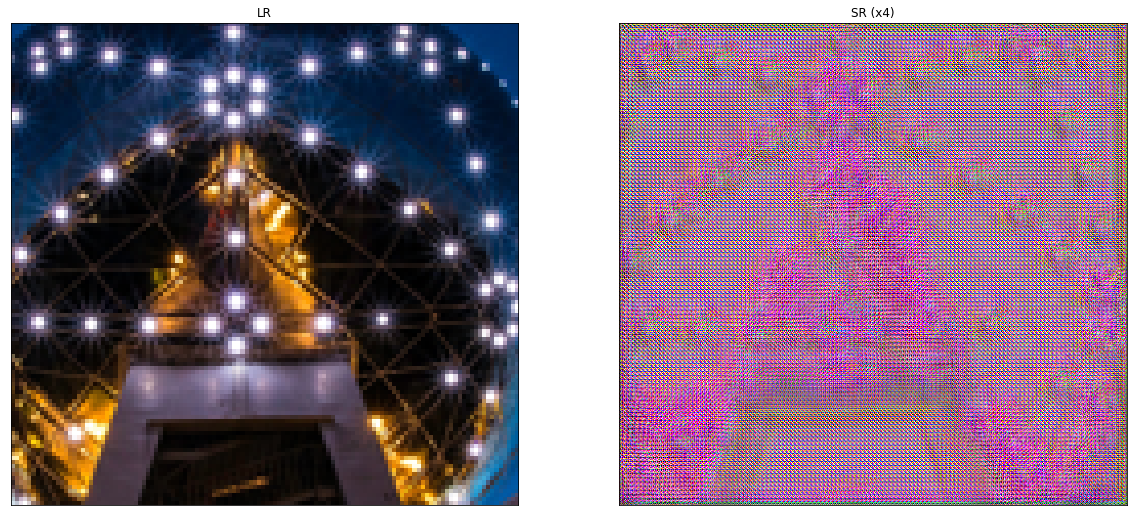

In [ ]:
resolve_and_plot('demo/0851x4-crop.png')